In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


sns.set(style='white', context='notebook', palette='deep')

# Data preparation

## Load the data

In [6]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [7]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train['label'].head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [9]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## Check for null and missing values

In [11]:
X_train.isnull().any().sum()

0

In [12]:
test.isnull().any().sum()

0

## Rescale and reshape

In [13]:
# Normalize
X_train = X_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label encoding

In [14]:
Y_train = to_categorical(Y_train, num_classes = 10)

# Training

In [15]:
# Split into training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

## Data augmentation

Data augmentation is important to prevent overfitting

In [16]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
)

datagen.fit(X_train)

## Define the model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=10, 
    restore_best_weights=True,
)

In [18]:
model = keras.Sequential([
    layers.InputLayer(shape=(28,28,1)),
    layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [19]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [21]:
train_generator = datagen.flow(X_train,Y_train, batch_size=86)

history = model.fit(train_generator,
                    epochs = 30, 
                    validation_data = (X_val,Y_val),
                    verbose = 2, 
                    steps_per_epoch=X_train.shape[0] // 86, 
                    callbacks=[early_stopping])

Epoch 1/30
439/439 - 150s - 341ms/step - accuracy: 0.9659 - loss: 0.1112 - val_accuracy: 0.9850 - val_loss: 0.0527
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 - 4s - 9ms/step - accuracy: 0.9535 - loss: 0.0655 - val_accuracy: 0.9852 - val_loss: 0.0497
Epoch 3/30
439/439 - 149s - 339ms/step - accuracy: 0.9732 - loss: 0.0888 - val_accuracy: 0.9879 - val_loss: 0.0377
Epoch 4/30
439/439 - 4s - 9ms/step - accuracy: 0.9884 - loss: 0.0377 - val_accuracy: 0.9874 - val_loss: 0.0383
Epoch 5/30
439/439 - 150s - 342ms/step - accuracy: 0.9760 - loss: 0.0763 - val_accuracy: 0.9888 - val_loss: 0.0356
Epoch 6/30
439/439 - 4s - 10ms/step - accuracy: 0.9884 - loss: 0.0204 - val_accuracy: 0.9883 - val_loss: 0.0376
Epoch 7/30
439/439 - 159s - 362ms/step - accuracy: 0.9798 - loss: 0.0661 - val_accuracy: 0.9888 - val_loss: 0.0404
Epoch 8/30
439/439 - 5s - 12ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9881 - val_loss: 0.0416
Epoch 9/30
439/439 - 149s - 339ms/step - accuracy: 0.9812 - loss: 0.0607 - val_accuracy: 0.9919 - val_loss: 0.0294
Epoch 10/30
439/439 - 4s - 10ms/step - accuracy: 0.9767 - loss: 0.0214 - val_accuracy: 0.9919 - val_loss:

# Evaluate the model

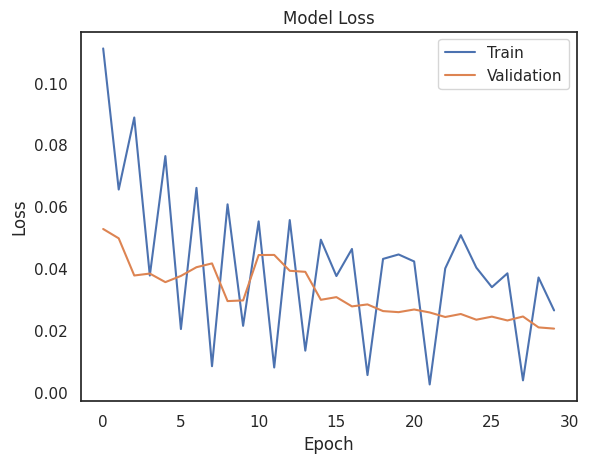

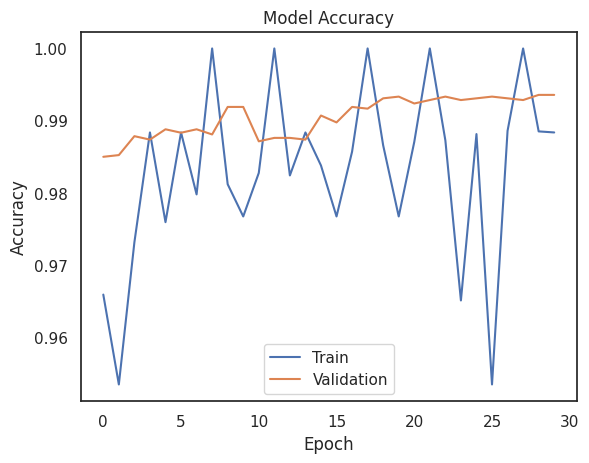

In [22]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Submit result

In [23]:
predictions = model.predict(test)

# select the indix with the maximum probability
predictions = np.argmax(predictions,axis = 1)

predictions = pd.Series(predictions,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step


In [25]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),predictions],axis = 1)

submission.to_csv("submission.csv",index=False)